In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1269.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/623.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/820.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1354.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/45.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/369.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1711.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1173.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1488.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/436.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1409.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/71.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1055.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/215.jpg
/

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-02 01:07:20.267661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746148040.467289      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746148040.526467      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_images_from_folder(dataset_path, img_size=224):
    # Detect if it's train or test
    if "train" in dataset_path.lower():
        dataset_type = "Training Dataset"
    elif "test" in dataset_path.lower():
        dataset_type = "Testing Dataset"
    else:
        dataset_type = "Unknown Dataset"

    images = []
    labels = []
    class_names = os.listdir(dataset_path)
    class_counts = {class_name: 0 for class_name in class_names}

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(label)
                class_counts[class_name] += 1

    images = np.array(images)
    labels = np.array(labels)

    print(f"\n Dataset Type: {dataset_type}")
    print(" Done loading images!")
    print("Total images:", len(images))
    print("Class names:", class_names)
    print("\n Image count per class:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    # ADD these returns
    return images, labels, class_counts, dataset_type

In [4]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_counts, dataset_type="Dataset"):
    """
    Plots the class distribution.

    Args:
        class_counts (dict): Dictionary with class names as keys and counts as values.
        dataset_type (str): Name of the dataset (for the title).
    """
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='skyblue', edgecolor='black')
    plt.title(f'Class Distribution in {dataset_type}', fontsize=16)
    plt.xlabel('Class Names', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


 Dataset Type: Training Dataset
 Done loading images!
Total images: 2637
Class names: ['benign', 'malignant']

 Image count per class:
benign: 1440 images
malignant: 1197 images


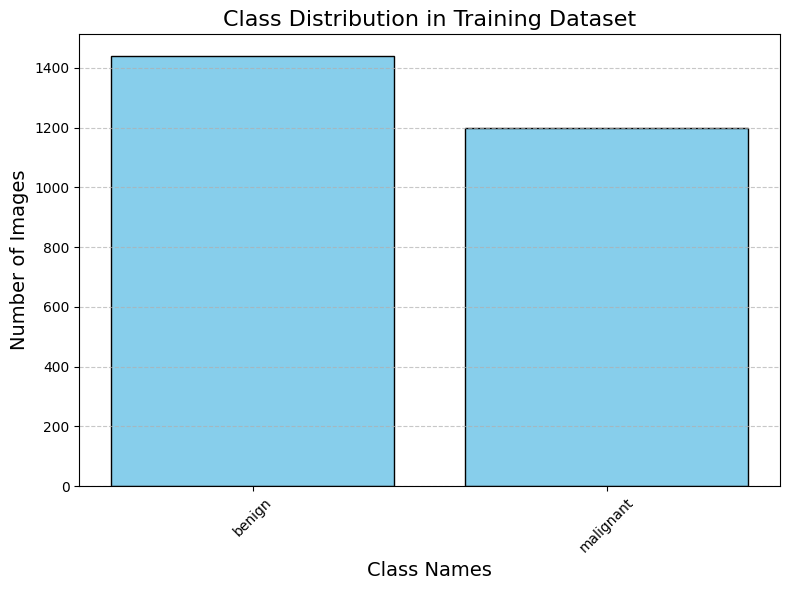

In [5]:
# Load the images
train_images,train_labels, train_class_counts, dataset_type = load_images_from_folder("/kaggle/input/skin-cancer-malignant-vs-benign/train")

# Plot the class distribution
plot_class_distribution(train_class_counts, dataset_type)


 Dataset Type: Testing Dataset
 Done loading images!
Total images: 660
Class names: ['benign', 'malignant']

 Image count per class:
benign: 360 images
malignant: 300 images


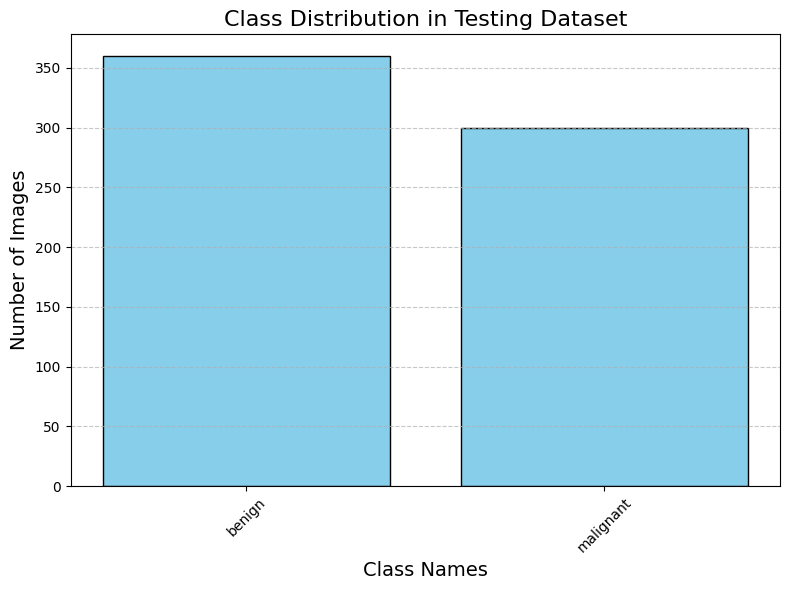

In [6]:
# Load the images
test_images,test_labels, test_class_counts, dataset_type = load_images_from_folder("/kaggle/input/skin-cancer-malignant-vs-benign/test")

# Plot the class distribution
plot_class_distribution(test_class_counts, dataset_type)

In [9]:
def plot_sample_images_per_class(images, labels, class_names, num_images_per_class=5, dataset_type="Dataset"):
    """
    Plots a few sample images from each class.

    Args:
        images (np.array): Array of all images.
        labels (np.array): Corresponding labels for images.
        class_names (list): List of class names.
        num_images_per_class (int): Number of images to plot per class.
        dataset_type (str): Dataset type (Train/Test) for the title.
    """
    import matplotlib.pyplot as plt

    # Create a figure
    plt.figure(figsize=(num_images_per_class * 3, len(class_names) * 3))

    img_idx = 1  # subplot index

    for class_idx, class_name in enumerate(class_names):
        # Get all indices of images belonging to this class
        class_indices = np.where(labels == class_idx)[0]
        
        # Randomly shuffle (optional) and select images
        selected_indices = np.random.choice(class_indices, min(num_images_per_class, len(class_indices)), replace=False)
        
        for idx in selected_indices:
            plt.subplot(len(class_names), num_images_per_class, img_idx)
            plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            plt.axis('off')
            plt.title(class_name, fontsize=10)
            img_idx += 1

    plt.suptitle(f'Sample Images from {dataset_type}', fontsize=18)
    plt.tight_layout()
    plt.show()

In [10]:
class_names = ['benign', 'malignant']

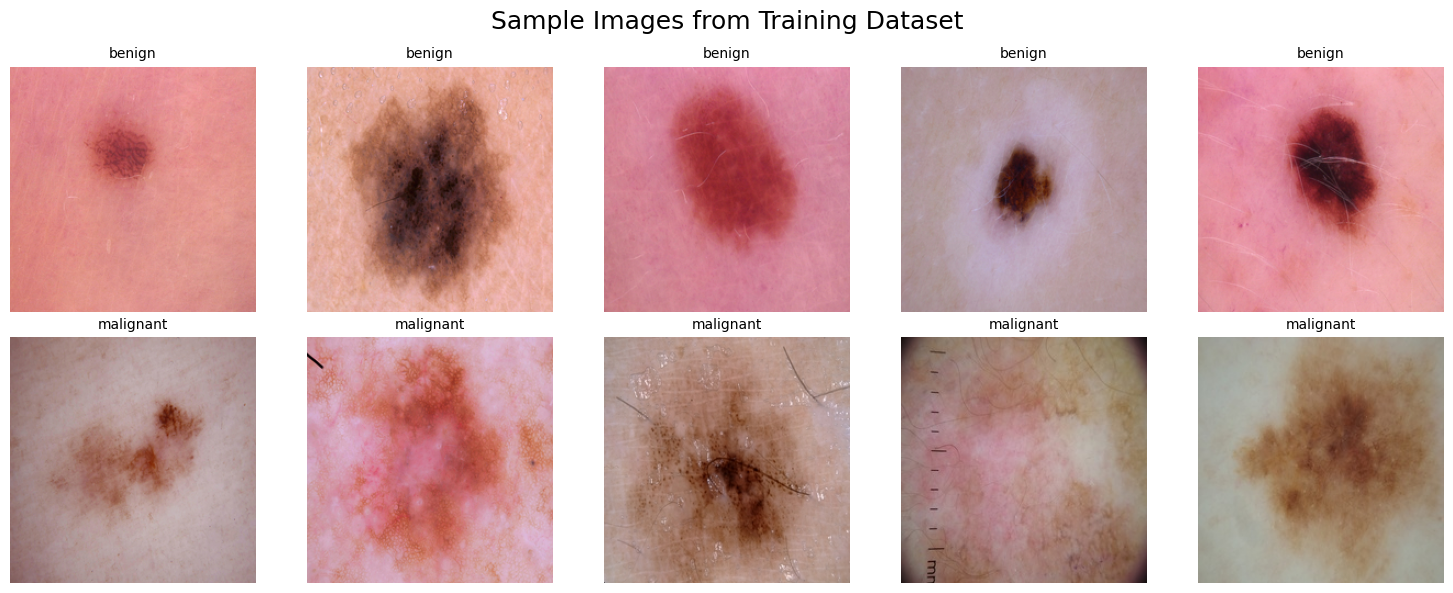

In [11]:
plot_sample_images_per_class(train_images,train_labels, class_names, num_images_per_class=5, dataset_type='Training Dataset')

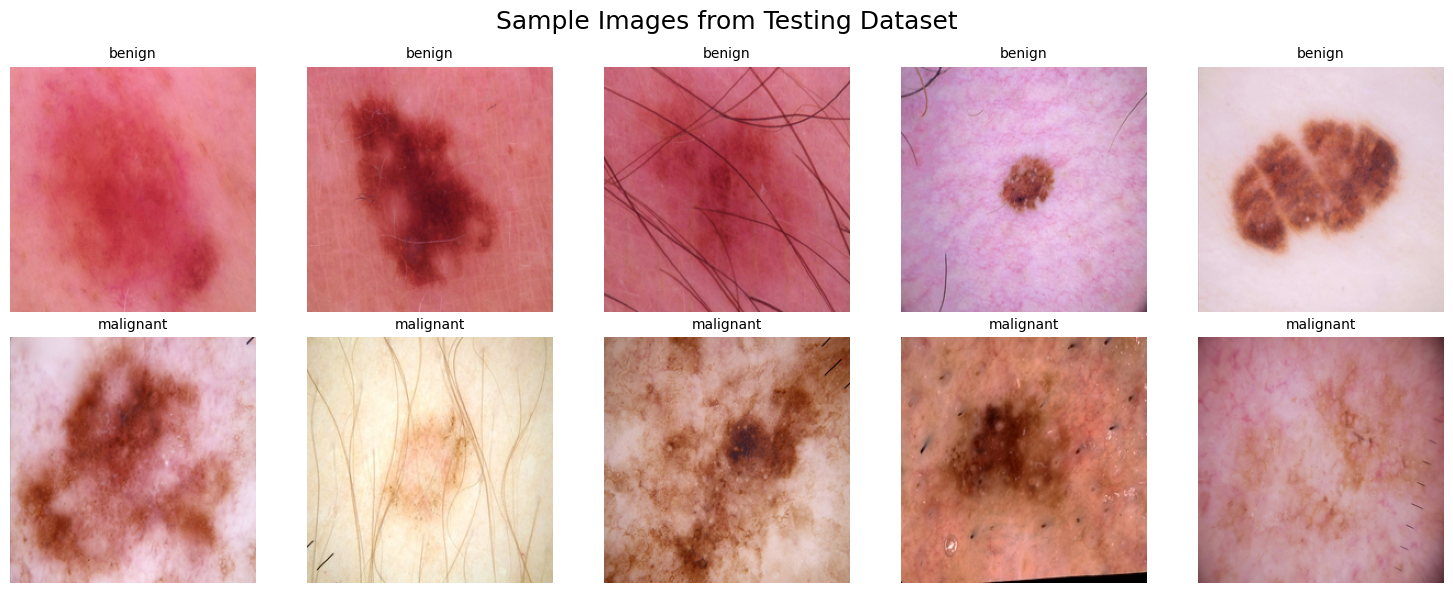

In [12]:
plot_sample_images_per_class(test_images,test_labels, class_names, num_images_per_class=5, dataset_type='Testing Dataset')

In [13]:
import os
import cv2
import numpy as np

def preprocess_and_enhance_image(img, img_size=224):
    """
    Preprocesses and enhances a single image.

    Steps:
        - Resize
        - Denoising (Median Blur)
        - Histogram Equalization (Contrast Enhancement)
        - Normalize pixel values (0-255) for saving
    """
    # 1. Resize
    img = cv2.resize(img, (img_size, img_size))

    # 2. Denoise
    img = cv2.medianBlur(img, 3)

    # 3. Histogram Equalization on Y channel
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    return img  # Keep values in 0-255 for saving

def preprocess_dataset(input_dataset_path, output_dataset_path, img_size=224):
    """
    Preprocesses images from the input dataset path and saves them into output dataset path.

    Args:
        input_dataset_path (str): Path to the original dataset.
        output_dataset_path (str): Path to save preprocessed dataset.
        img_size (int): Size to resize images (default 224).
    """
    # Create the output root folder if it doesn't exist
    if not os.path.exists(output_dataset_path):
        os.makedirs(output_dataset_path)
        print(f"Created folder: {output_dataset_path}")

    # Loop through each class
    for class_name in os.listdir(input_dataset_path):
        input_class_path = os.path.join(input_dataset_path, class_name)

        # Ensure it is a directory
        if os.path.isdir(input_class_path):
            output_class_path = os.path.join(output_dataset_path, class_name)
            os.makedirs(output_class_path, exist_ok=True)  # Create class folder if not exists

            # Loop through each image in the class
            for img_name in os.listdir(input_class_path):
                img_path = os.path.join(input_class_path, img_name)
                img = cv2.imread(img_path)

                if img is not None:
                    enhanced_img = preprocess_and_enhance_image(img, img_size)
                    
                    # Save the enhanced image
                    save_path = os.path.join(output_class_path, img_name)
                    cv2.imwrite(save_path, enhanced_img)

            print(f"Finished preprocessing class: {class_name}")

    print("\n✅ Preprocessing completed for all classes!")

In [14]:
input_dataset_path = "/kaggle/input/skin-cancer-malignant-vs-benign/train"
output_dataset_path = "/kaggle/working/preprocess/train" 

preprocess_dataset(input_dataset_path, output_dataset_path, img_size=224)

Created folder: /kaggle/working/preprocess/train
Finished preprocessing class: benign
Finished preprocessing class: malignant

✅ Preprocessing completed for all classes!


In [15]:
input_dataset_path = "/kaggle/input/skin-cancer-malignant-vs-benign/test"
output_dataset_path = "/kaggle/working/preprocess/test" 

preprocess_dataset(input_dataset_path, output_dataset_path, img_size=224)

Created folder: /kaggle/working/preprocess/test
Finished preprocessing class: benign
Finished preprocessing class: malignant

✅ Preprocessing completed for all classes!


In [16]:
import os
import random
import matplotlib.pyplot as plt
import cv2

def plot_original_vs_preprocessed(original_dataset_path, preprocessed_dataset_path, class_name, num_images=5):
    """
    Plots side-by-side comparison of original vs preprocessed images.

    Args:
        original_dataset_path (str): Path to original dataset folder.
        preprocessed_dataset_path (str): Path to preprocessed dataset folder.
        class_name (str): Name of the class to sample images from.
        num_images (int): Number of images to plot.
    """
    orig_class_path = os.path.join(original_dataset_path, class_name)
    preproc_class_path = os.path.join(preprocessed_dataset_path, class_name)

    # Safety check
    if not os.path.exists(orig_class_path):
        print(f"Original class folder '{class_name}' not found!")
        return
    if not os.path.exists(preproc_class_path):
        print(f"Preprocessed class folder '{class_name}' not found!")
        return

    # List available images
    orig_images = os.listdir(orig_class_path)
    preproc_images = os.listdir(preproc_class_path)

    # Take the minimum to avoid index errors
    num_images = min(num_images, len(orig_images), len(preproc_images))

    # Randomly select images
    selected_indices = random.sample(range(len(orig_images)), num_images)

    plt.figure(figsize=(num_images * 4, 8))

    for i, idx in enumerate(selected_indices):
        # Load original
        orig_img_path = os.path.join(orig_class_path, orig_images[idx])
        orig_img = cv2.imread(orig_img_path)
        if orig_img is not None:
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

        # Load preprocessed
        preproc_img_path = os.path.join(preproc_class_path, preproc_images[idx])
        preproc_img = cv2.imread(preproc_img_path)
        if preproc_img is not None:
            preproc_img = cv2.cvtColor(preproc_img, cv2.COLOR_BGR2RGB)

        # Plot original
        plt.subplot(2, num_images, i+1)
        plt.imshow(orig_img)
        plt.title("Original")
        plt.axis('off')

        # Plot preprocessed
        plt.subplot(2, num_images, i+1+num_images)
        plt.imshow(preproc_img)
        plt.title("Preprocessed")
        plt.axis('off')

    plt.suptitle(f"Comparison for Class: {class_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

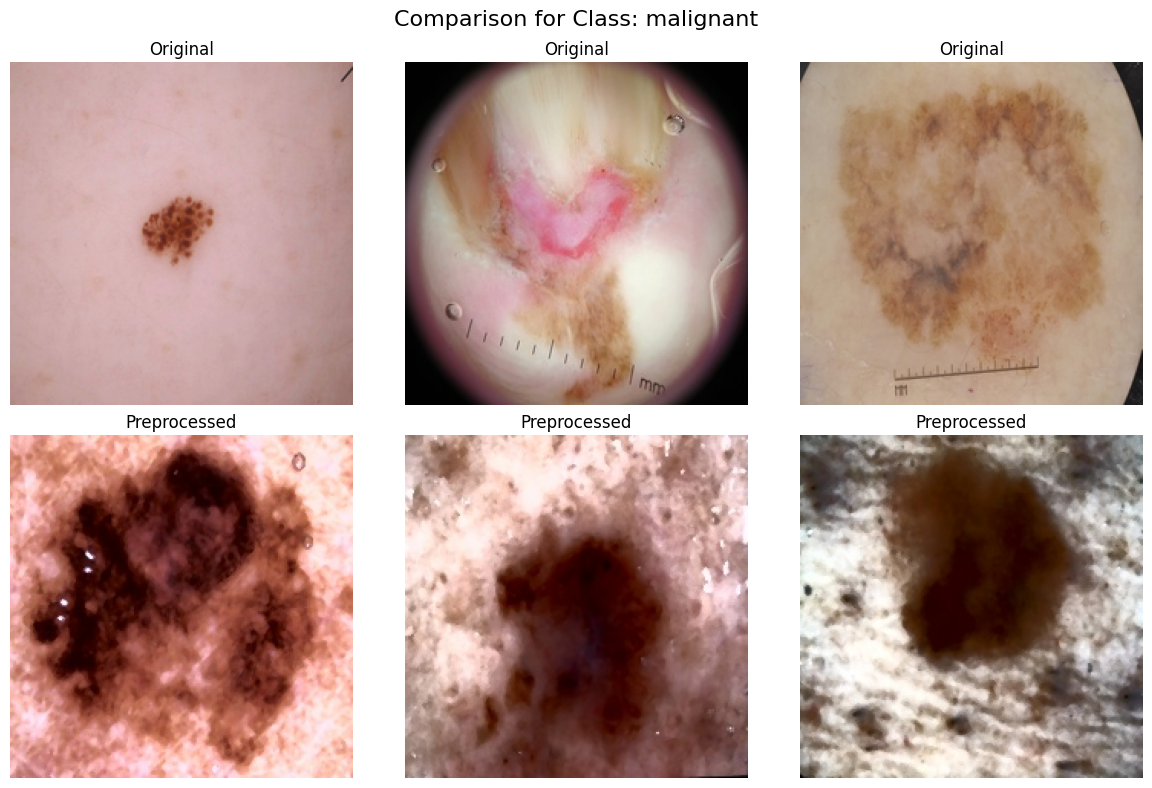

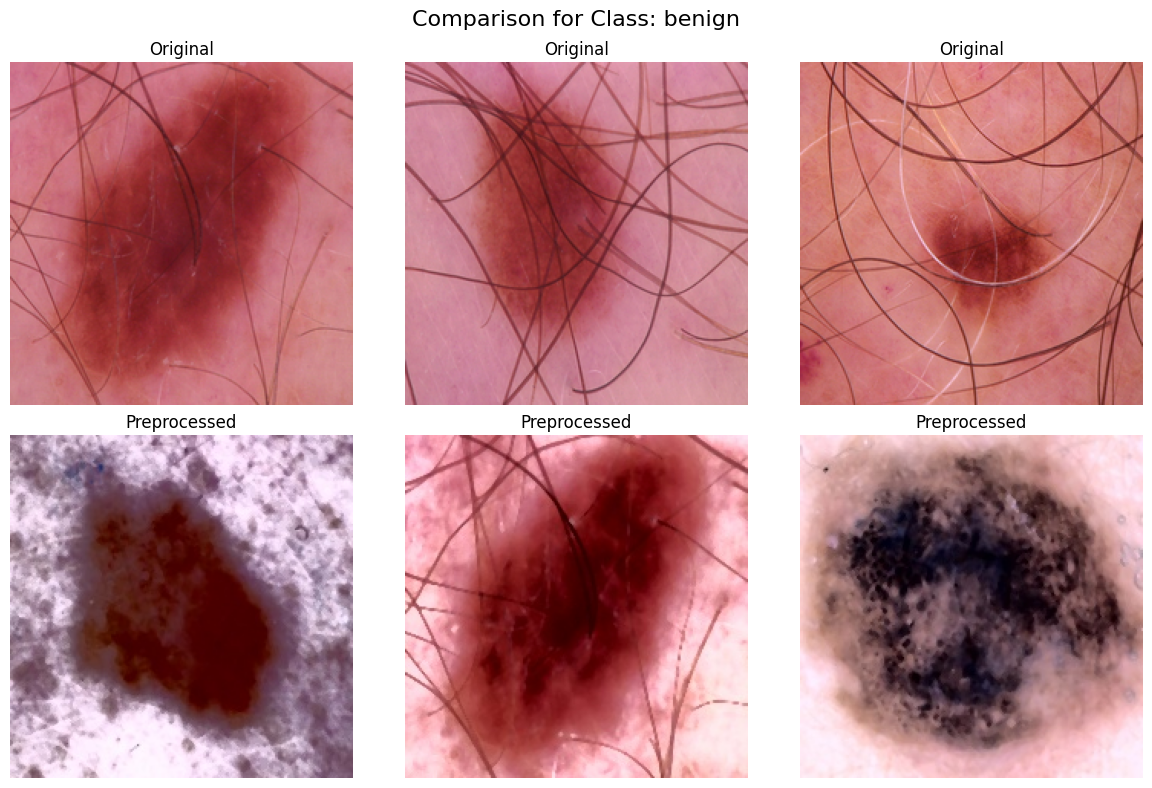

In [17]:
original_dataset_path = "/kaggle/input/skin-cancer-malignant-vs-benign/train"
preprocessed_dataset_path = "/kaggle/working/preprocess/train"

plot_original_vs_preprocessed(original_dataset_path, preprocessed_dataset_path, class_name= 'malignant', num_images=3)
plot_original_vs_preprocessed(original_dataset_path, preprocessed_dataset_path, class_name= 'benign', num_images=3)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.utils import plot_model

# =====================================================================
#                        Configuration
# =====================================================================
dataset_dir = "/kaggle/working/preprocess/train"
img_size = (224, 224)
batch_size = 32
seed = 123
num_classes = 2  # Update with your actual number of classes

In [19]:
# =====================================================================
#                     Simplified Dataset Loading
# =====================================================================
# Load training data (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle = True
)

# Load temporary validation+test data (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle = True
)

# Optimize data loading
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 2637 files belonging to 2 classes.
Using 2110 files for training.


I0000 00:00:1745989996.888713      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 2637 files belonging to 2 classes.
Using 527 files for validation.


In [20]:
class MCD_GRU(tf.keras.Model):
    def __init__(self, num_classes):
        super(MCD_GRU, self).__init__()
        
        # Backbones (frozen)
        self.vgg = applications.VGG16(include_top=False, weights='imagenet')
        self.densenet = applications.DenseNet121(include_top=False, weights='imagenet')
        self.vgg.trainable = False
        self.densenet.trainable = False
        
        # Base CNN
        self.base_cnn = models.Sequential([
            layers.Conv2D(64, (3,3), activation='relu'),
            layers.MaxPooling2D(2,2),
            layers.Conv2D(128, (3,3), activation='relu'),
            layers.GlobalAveragePooling2D()
        ])
        
        # Feature Fusion
        self.flatten = layers.Flatten()
        self.fusion = layers.Concatenate()
        
        # GRU + Classifier
        self.gru = layers.GRU(128)
        self.classifier = models.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        # Process through backbones
        vgg = self.vgg(inputs)
        densenet = self.densenet(inputs)
        base = self.base_cnn(inputs)

        # Flatten outputs
        vgg = self.flatten(vgg)          # ✅ Use class-level layer
        densenet = self.flatten(densenet)
        base = self.flatten(base)        # Now tracked by the model
        
        # Concatenate features
        fused = self.fusion([vgg, densenet, base])
        
        # Reshape for GRU (add timestep dimension)
        gru_input = tf.expand_dims(fused, axis=1)
        
        # Process through GRU
        gru_out = self.gru(gru_input)
        
        return self.classifier(gru_out)

In [21]:
# =====================================================================
#                        Model Setup
# =====================================================================
# Initialize model
# Initialize and build properly
model = MCD_GRU(num_classes=2)

# Force model building with concrete shapes
dummy_input = tf.keras.Input(shape=(224, 224, 3))
_ = model(dummy_input)  # Critical step!

model.summary()
# Visualize architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True)
print("\n✅ Model diagram saved to model_architecture.png")

# Compile model
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',  # Changed to match dataset format
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mcd_gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, None, None, 512)     │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, None, None, 1024)    │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128)                 │          75,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ concatenate (Concatenate)            │ (None, 75392)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │      29,000,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 2)                   │          67,074 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,895,362 (194.15 MB)

 Trainable params: 29,143,170 (111.17 MB)

 Non-trainable params: 21,752,192 (82.98 MB)


✅ Model diagram saved to model_architecture.png


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',      # Watch validation loss
    patience=5,              # Wait for 3 epochs with no improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)


# In model.fit()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping],  # <--- Add this line,
    shuffle = False
)


Epoch 1/50


I0000 00:00:1745990028.429842     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.7398 - loss: 0.5231 - val_accuracy: 0.8197 - val_loss: 0.3802
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - accuracy: 0.8270 - loss: 0.3609 - val_accuracy: 0.8558 - val_loss: 0.3488
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.8509 - loss: 0.3253 - val_accuracy: 0.8482 - val_loss: 0.3281
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.8643 - loss: 0.2817 - val_accuracy: 0.8729 - val_loss: 0.3161
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 251ms/step - accuracy: 0.8789 - loss: 0.2671 - val_accuracy: 0.8387 - val_loss: 0.3508
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 251ms/step - accuracy: 0.8942 - loss: 0.2517 - val_accuracy: 0.8539 - val_loss: 0.3219
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - accuracy: 0.9156 - loss: 0.2162 - val_accuracy: 0.8558 - val_loss: 0.3087
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 251ms/step - accuracy: 0.9229 - loss: 0.1981 - val_accuracy: 0.840

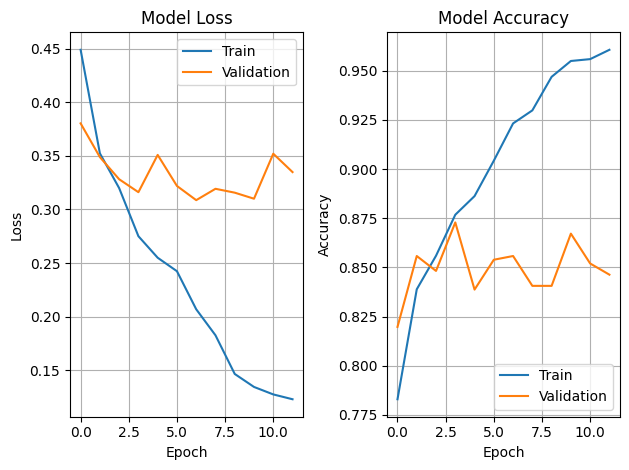

In [23]:
# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])  # Use 'acc' if you get KeyError
plt.plot(history.history['val_accuracy'])  # Use 'val_acc' if you get KeyError
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/preprocess/test',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle = False
)

Found 660 files belonging to 2 classes.


In [25]:
model.evaluate(test_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.8430 - loss: 0.3246


[0.31153082847595215, 0.8575757741928101]

In [26]:
ts_length = len(test_ds)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_ds, steps= test_steps, verbose= 1)
valid_score = model.evaluate(val_ds, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_ds)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9375 - loss: 0.2329
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9062 - loss: 0.2540
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.8430 - loss: 0.3246
Train Loss:  0.23286142945289612
Train Accuracy:  0.9375
--------------------
Validation Loss:  0.25403398275375366
Validation Accuracy:  0.90625
--------------------
Test Loss:  0.31153082847595215
Test Accuracy:  0.8575757741928101


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(y_true, y_pred, class_names):
    """
    Plots the confusion matrix and prints the classification report.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        class_names (list): List of class names.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step

Classification Report:

              precision    recall  f1-score   support

      Benign       0.88      0.85      0.87       360
   Malignant       0.83      0.87      0.85       300

    accuracy                           0.86       660
   macro avg       0.86      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660



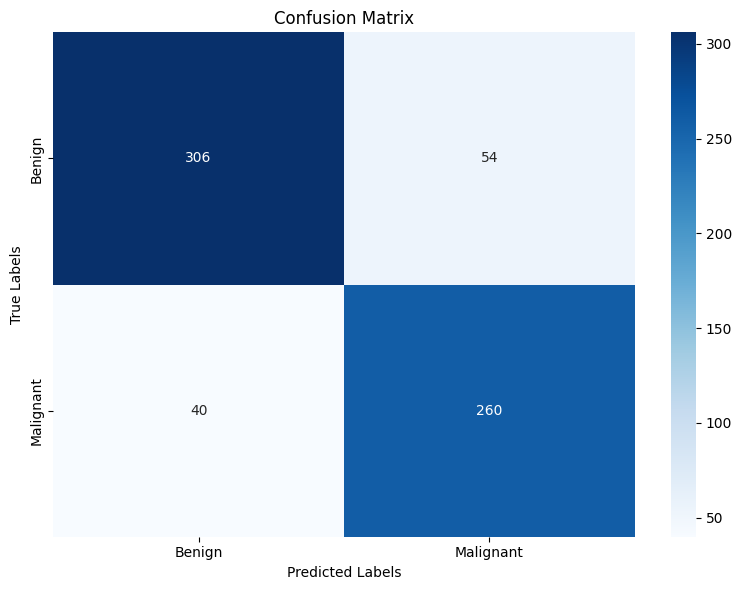

In [28]:
# 1. Predict
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. True labels
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# 3. Class names
class_names = ['Benign', 'Malignant']

# 4. Evaluate 
evaluate_model(y_true, y_pred, class_names)

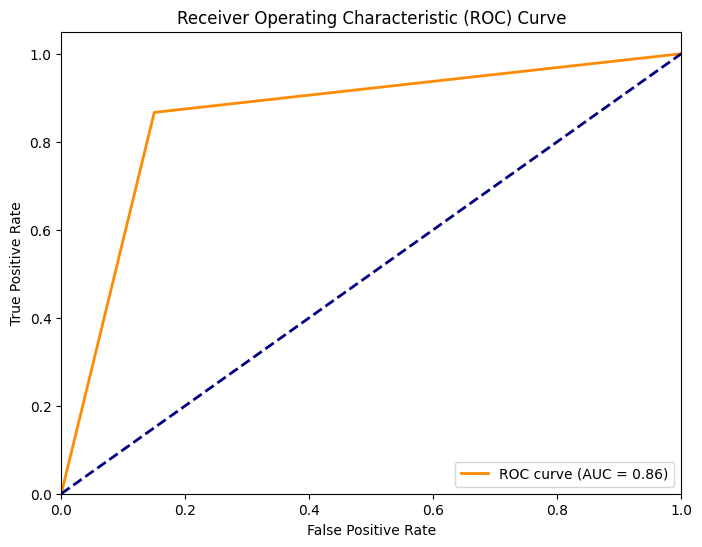

In [29]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()